In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
%matplotlib inline

from nanonets.utils import load_boolean_results, abundance, fitness, abundance_plot, nonlinear_parameter, return_ndr, return_nls
from nanonets import Simulation
from typing import Tuple, List, Dict

plt.style.use(["science","bright","grid"])

# PATH_wo_scale   = "/home/jonasmensing/bagheera/data/1_funding_period/system_size/duration/wo_scale/new/"
# PATH_wo_scale   = "/home/j/j_mens07/phd/data/1_funding_period/system_size/wo_scale/new/"
PATH_wo_scale   = "/home/j/j_mens07/bagheera/data/1_funding_period/system_size/duration/wo_scale/new/"
# PATH_scale      = "/home/jonasmensing/bagheera/data/1_funding_period/system_size/duration/scale/new/"
# PATH_scale      = "/home/j/j_mens07/phd/data/1_funding_period/system_size/scale/new/"
PATH_scale      = "/home/j/j_mens07/bagheera/data/1_funding_period/system_size/duration/scale/new/"
# PATH_int_scale  = "/home/jonasmensing/bagheera/data/1_funding_period/system_size/duration/internal_scale/"
GATES           = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']

In [3]:
# Parameter
N_min   = 3
N_max   = 7
N_keys  = N_max-N_min+1
N_vals  = [i for i in range(N_min,N_max+1)]
N_e     = 8
delta   = 0.0
ele     = 0.160217662
actime  = 40e-9
batch_t = 20*actime
I_min   = ele / (20*batch_t)

In [4]:
n = 13
topo = {"Nx": n, "Ny": n,
        "e_pos" : [[0,0], 
                    [int((n-1)/2),0],
                    [n-1,0], 
                    [0,int((n-1)/2)],
                    [0,n-1],
                    [n-1,int((n)/2)],
                    [int((n)/2),(n-1)],
                    [n-1,n-1]],
        "electrode_type" : ['constant']*8}
sim_class = Simulation(topo)
c_inv = sim_class.get_inv_capacitance_matrix()
c_dia = np.diag(c_inv)
E_jou = (Simulation.ELE_CHARGE_A_C**2) * c_dia/2
E_th  = 0.1*sim_class.KB_AJ_PER_K

In [ ]:
# Np = sim_instance.N_particles
# diag_elements = np.diag(C_inv)[:Np]

# E_c_joules = 0.5 * (e**2) * diag_elements
# E_c_meV    = (E_c_joules / e) * 1000  # Convert to meV

# # 3. Calculate Comparison Scales
# T_kelvin = sim_instance.T
# E_thermal_meV = (kB * T_kelvin / e) * 1000
# E_drive_meV   = v_bias_max * 1000

### Load Data

In [28]:
data_wo_scale   = load_boolean_results(folder=PATH_wo_scale, N=N_vals, N_e=8, input_cols=["E1","E3"], drop_zero=False)
data_scale      = load_boolean_results(folder=PATH_scale, N=N_vals, N_e=8, input_cols=["E1","E3"], drop_zero=False)
# for N in N_vals:
#     y = data_wo_scale[N]['Observable'].values.copy()
#     ye = data_wo_scale[N]['Error'].values.copy()
#     y[np.abs(y) < I_min] = 0.0
#     ye[np.abs(y) < I_min] = 0.0
#     data_wo_scale[N]['Observable'] = y
#     data_wo_scale[N]['Error'] = ye

#     y = data_scale[N]['Observable'].values.copy()
#     ye = data_scale[N]['Error'].values.copy()
#     y[np.abs(y) < I_min] = 0.0
#     ye[np.abs(y) < I_min] = 0.0
#     data_scale[N]['Observable'] = y
#     data_scale[N]['Error'] = ye

In [31]:
# N   = 7
# I10 = data_wo_scale[N][(data_wo_scale[N]['E1']==0.01) & (data_wo_scale[N]['E3']==0.0)]['Observable'].values
# I01 = data_wo_scale[N][(data_wo_scale[N]['E1']==0.0) & (data_wo_scale[N]['E3']==0.01)]['Observable'].values
# I11 = data_wo_scale[N][(data_wo_scale[N]['E1']==0.01) & (data_wo_scale[N]['E3']==0.01)]['Observable'].values
# IS  = I10+I01

# fig = plt.figure(dpi=300)
# ax  = fig.add_subplot()
# _   = ax.plot(IS*1e-6, I11*1e-6, marker='.', ls='')
# _   = ax.plot(IS*1e-6,IS*1e-6)
# _   = ax.set_ylabel("I11")
# _   = ax.set_xlabel("I01+I10")

### Fitness, delta=0

In [32]:
M_resamples         = 0
fitness_wo_scale    = {N : fitness(data_wo_scale[N], input_cols=['E1','E3'], M=M_resamples, delta=delta) for N in data_wo_scale.keys()}
fitness_scale       = {N : fitness(data_scale[N], input_cols=['E1','E3'], M=M_resamples, delta=delta) for N in data_scale.keys()}

In [33]:
fitness_melted = pd.DataFrame()
for gate in GATES:
    df              = pd.DataFrame([fitness_wo_scale[key].loc[:,f'{gate} Fitness'].copy().values for key in N_vals],index=np.array(N_vals)).T
    df              = df.melt(var_name='$N_{NP}$', value_name='$Fitness$').dropna().reset_index(drop=True)
    df['Gate']      = gate
    df['scale']     = 'None'
    fitness_melted  = pd.concat([fitness_melted,df]).reset_index(drop=True)

for gate in GATES:
    df              = pd.DataFrame([fitness_scale[key].loc[:,f'{gate} Fitness'].copy().values for key in N_vals],index=np.array(N_vals)).T
    df              = df.melt(var_name='$N_{NP}$', value_name='$Fitness$').dropna().reset_index(drop=True)
    df['Gate']      = gate
    df['scale']     = 'Input'
    fitness_melted  = pd.concat([fitness_melted,df]).reset_index(drop=True)

fitness_melted

,$N_{NP}$,$Fitness$,Gate,scale
0,3,0.914006,AND,None
1,3,1.419981,AND,None
2,3,2.084506,AND,None
3,3,1.545600,AND,None
4,3,1.388814,AND,None
...,...,...,...,...
1062835,7,-1.963261,NOR,Input
1062836,7,-2.432943,NOR,Input
1062837,7,-1.704639,NOR,Input
1062838,7,0.059684,NOR,Input


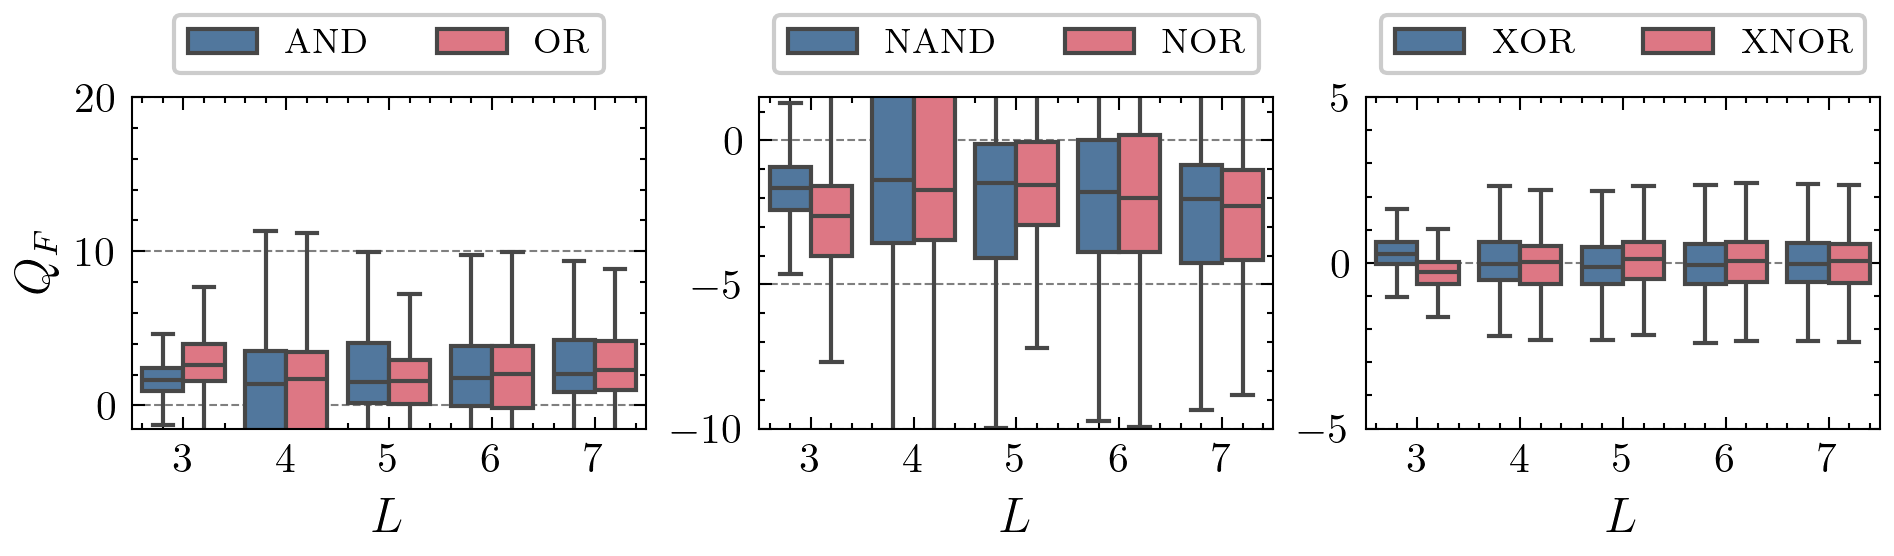

In [35]:
fig = plt.figure(dpi=300, layout='constrained')
fig.set_figheight(fig.get_figheight()*0.7)
fig.set_figwidth(fig.get_figwidth()*1.8)

# w, h    = fig.get_size_inches()
# scale   = 0.75
# fig.set_size_inches(w * scale, h * scale)

for i, g_comb in enumerate([['AND','OR'],['NAND','NOR'],['XOR','XNOR']]):
    df  = fitness_melted[fitness_melted['scale']=='Input'].copy()
    df  = df[(df['Gate']==g_comb[0])|(df['Gate']==g_comb[1])]
    # df  = df[df['$Fitness$'].abs() < 10]
    ax  = fig.add_subplot(1,3,i+1)
    ax  = sns.boxplot(data=df, x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, fliersize=0.)
    # ax  = sns.violinplot(data=df, x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, inner=None, density_norm='width', gridsize=500)
    leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.16), ncol=2, fontsize='small')
    leg.set_in_layout(True)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("$Q_F$", fontsize='large')
    if i == 0:
        # ax.set_ylim(-1,7)
        ax.set_ylim(-1.5,20)
    elif i == 1:
        # ax.set_ylim(-7,1)
        ax.set_ylim(-10,1.5)
    else:
        # ax.set_ylim(-1.2,1.2)
        ax.set_ylim(-5,5)
    # plt.xticks(rotation=90)
    ax.set_xlabel("$L$", fontsize='large')

# fig.savefig("plots/pdf/fitness_vs_L_gate_comp_scaled.pdf", transparent=False)
# fig.savefig("plots/png/fitness_vs_L_gate_comp_scaled.png", transparent=False)
# fig.savefig("plots/svg/fitness_vs_L_gate_comp_scaled.svg", transparent=True)

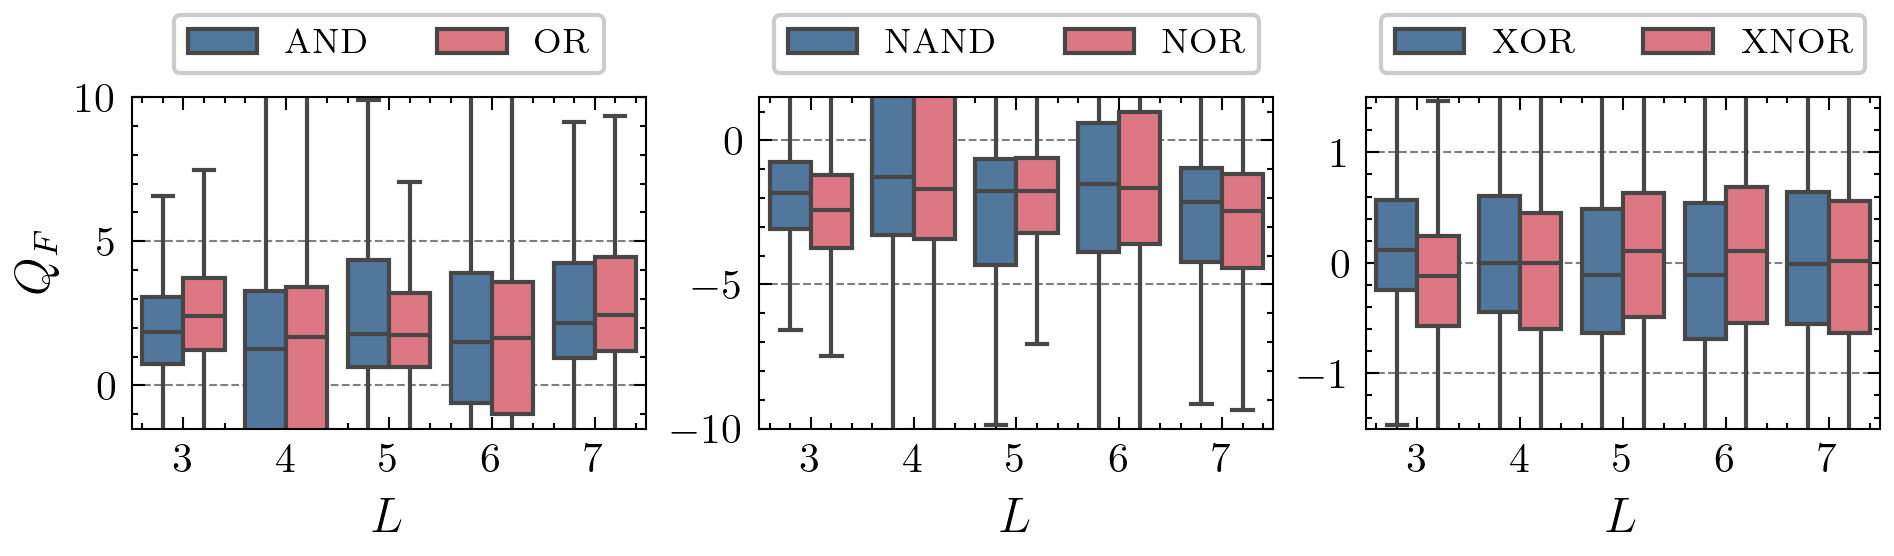

In [36]:
fig = plt.figure(dpi=300, layout='constrained')
fig.set_figheight(fig.get_figheight()*0.7)
fig.set_figwidth(fig.get_figwidth()*1.8)

# w, h    = fig.get_size_inches()
# scale   = 0.75
# fig.set_size_inches(w * scale, h * scale)

for i, g_comb in enumerate([['AND','OR'],['NAND','NOR'],['XOR','XNOR']]):
    df  = fitness_melted[fitness_melted['scale']=='None'].copy()
    df  = df[(df['Gate']==g_comb[0])|(df['Gate']==g_comb[1])]
    # df  = df[df['$Fitness$'].abs() < 10]
    ax  = fig.add_subplot(1,3,i+1)
    ax  = sns.boxplot(data=df, x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, fliersize=0.)
    # ax  = sns.violinplot(data=df, x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, inner=None, density_norm='width', gridsize=500)
    leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.16), ncol=2, fontsize='small')
    leg.set_in_layout(True)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("$Q_F$", fontsize='large')
    if i == 0:
        # ax.set_ylim(-1,7)
        ax.set_ylim(-1.5,10)
    elif i == 1:
        # ax.set_ylim(-7,1)
        ax.set_ylim(-10,1.5)
    else:
        # ax.set_ylim(-1.2,1.2)
        ax.set_ylim(-1.5,1.5)
    # plt.xticks(rotation=90)
    ax.set_xlabel("$L$", fontsize='large')

# fig.savefig("plots/pdf/fitness_vs_L_gate_comp_unscaled.pdf", transparent=False)
# fig.savefig("plots/png/fitness_vs_L_gate_comp_unscaled.png", transparent=False)
# fig.savefig("plots/svg/fitness_vs_L_gate_comp_unscaled.svg", transparent=True)

In [37]:
B = 0
if B == 0:
    q_ndr_vals_scale    = np.array([np.array([return_ndr(df.loc[:,['Ml','Mr']].mean(axis=1).values) for df in [nonlinear_parameter(data_scale[N], on_state=None, n_bootstrap=B)]]) for N in N_vals])
    q_ndr_vals_wo_scale = np.array([np.array([return_ndr(df.loc[:,['Ml','Mr']].mean(axis=1).values) for df in [nonlinear_parameter(data_wo_scale[N], on_state=None, n_bootstrap=B)]]) for N in N_vals])
else:
    q_ndr_vals_scale    = np.array([np.array([return_ndr(df.loc[:,['Ml','Mr']].mean(axis=1).values) for df in nonlinear_parameter(data_scale[N], on_state=None, n_bootstrap=B)]) for N in N_vals])
    q_ndr_vals_wo_scale = np.array([np.array([return_ndr(df.loc[:,['Ml','Mr']].mean(axis=1).values) for df in nonlinear_parameter(data_wo_scale[N], on_state=None, n_bootstrap=B)]) for N in N_vals])

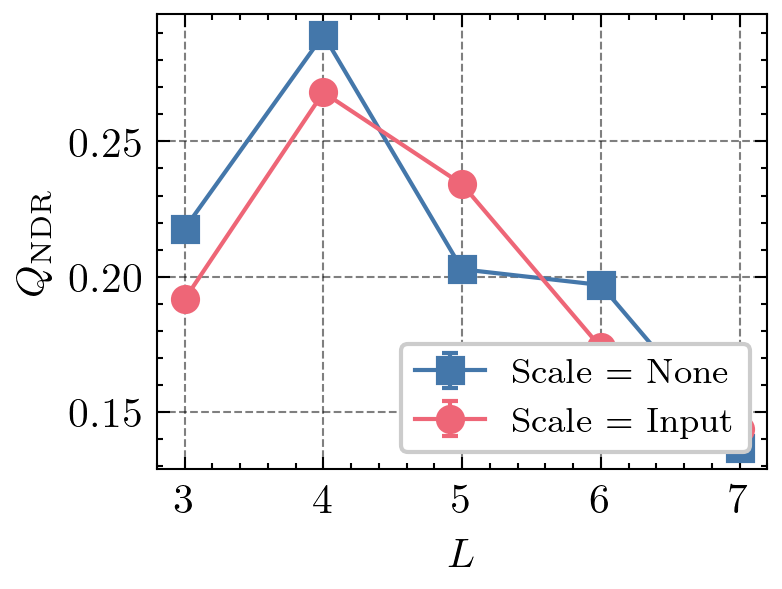

In [38]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.errorbar(N_vals, np.mean(q_ndr_vals_wo_scale,axis=1), 1.96*np.std(q_ndr_vals_wo_scale,axis=1), marker='s', capsize=2, label='Scale = None')
_   = ax.errorbar(N_vals, np.mean(q_ndr_vals_scale,axis=1), 1.96*np.std(q_ndr_vals_scale,axis=1), marker='o', capsize=2, label='Scale = Input')
_   = ax.set_xticks(N_vals)
_   = ax.set_ylabel("$Q_\\textrm{NDR}$")
_   = ax.set_xlabel("$L$")
_   = ax.legend(fontsize='small', loc='lower right')

# fig.savefig("plots/pdf/Q_NDR_vs_L.pdf", transparent=False)
# fig.savefig("plots/png/Q_NDR_vs_L.png", transparent=False)
# fig.savefig("plots/svg/Q_NDR_vs_L.svg", transparent=True)

In [39]:
B = 0
if B == 0:
    q_nls_vals_scale    = np.array([np.array([return_nls(df) for df in [nonlinear_parameter(data_scale[N], on_state=None, n_bootstrap=B)]]) for N in N_vals])
    q_nls_vals_wo_scale = np.array([np.array([return_nls(df) for df in [nonlinear_parameter(data_wo_scale[N], on_state=None, n_bootstrap=B)]]) for N in N_vals])
else:
    q_nls_vals_scale    = np.array([np.array([return_nls(df) for df in nonlinear_parameter(data_scale[N], on_state=None, n_bootstrap=B)]) for N in N_vals])
    q_nls_vals_wo_scale = np.array([np.array([return_nls(df) for df in nonlinear_parameter(data_wo_scale[N], on_state=None, n_bootstrap=B)]) for N in N_vals])

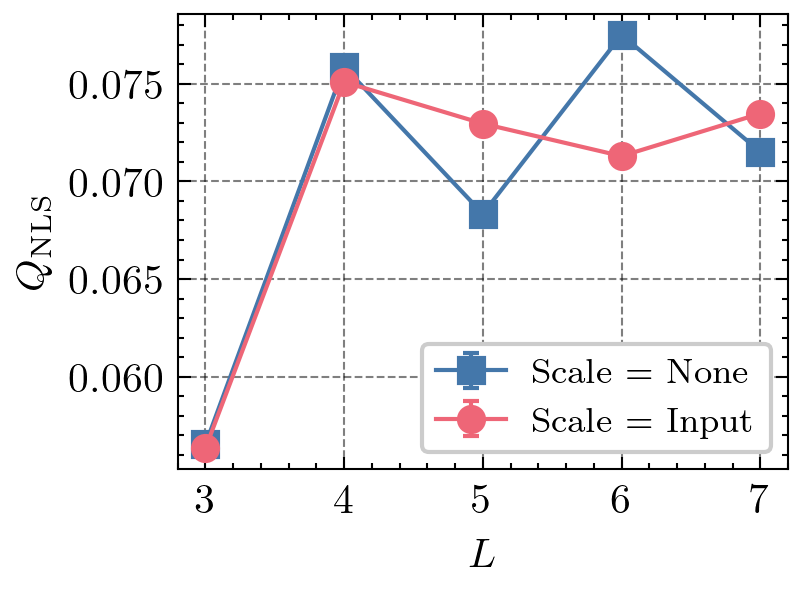

In [40]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.errorbar(N_vals, np.mean(q_nls_vals_wo_scale,axis=1), 1.96*np.std(q_nls_vals_wo_scale,axis=1), marker='s', capsize=2, label='Scale = None')
_   = ax.errorbar(N_vals, np.mean(q_nls_vals_scale,axis=1), 1.96*np.std(q_nls_vals_scale,axis=1), marker='o', capsize=2, label='Scale = Input')
_   = ax.set_xticks(N_vals)
_   = ax.set_ylabel("$Q_\\textrm{NLS}$")
_   = ax.set_xlabel("$L$")
_   = ax.legend(fontsize='small', loc='lower right')

# fig.savefig("plots/pdf/Q_NLS_vs_L.pdf", transparent=False)
# fig.savefig("plots/png/Q_NLS_vs_L.png", transparent=False)
# fig.savefig("plots/svg/Q_NLS_vs_L.svg", transparent=True)

### Abundance

In [19]:
def abundance_multiplot(data: Dict, gates: List[str] = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR'], 
    dpi: int = 300, x_limits: List[float] = [0.45, 10], y_limits: List[float] = [0.2, 100], 
    xlabel: str = "$Q_F$", ylabel: str = 'Abundance [\%]', n_rows=2, n_cols=3, colormap='cividis') -> Tuple[plt.Figure, plt.Axes]:

    cmap    = plt.get_cmap(colormap)
    N_vals  = len(data.keys())

    with plt.style.context(["science","bright","grid"]):
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, dpi=dpi, layout='constrained')
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.1)
        w, h    = fig.get_size_inches()
        scale   = 0.75
        fig.set_size_inches(w * scale, h * scale)

        for i, gate in enumerate(gates):
            ax      = axes.flat[i]
            keys    = []
            for j, (key, df) in enumerate(data.items()):
                ax.plot(df[f'{gate} Fitness'], df[f'{gate} Fitness Abundance'], color=cmap((j)/N_vals))
                keys.append(key)
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_limits[0], y_limits[1])
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            if i >= (n_rows-1)*n_cols:
                ax.set_xlabel(xlabel)
            else:
                ax.set_xticklabels("")

            if i % n_cols == 0:
                ax.set_ylabel(ylabel)
            else:
                ax.set_yticklabels("")

            ax.set_title(gate)

        norm    = mpl.colors.Normalize(vmin=np.min(keys), vmax=np.max(keys))
        cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
        fig.colorbar(cbar, ax=axes.ravel(), label='$L$')

    return fig, ax

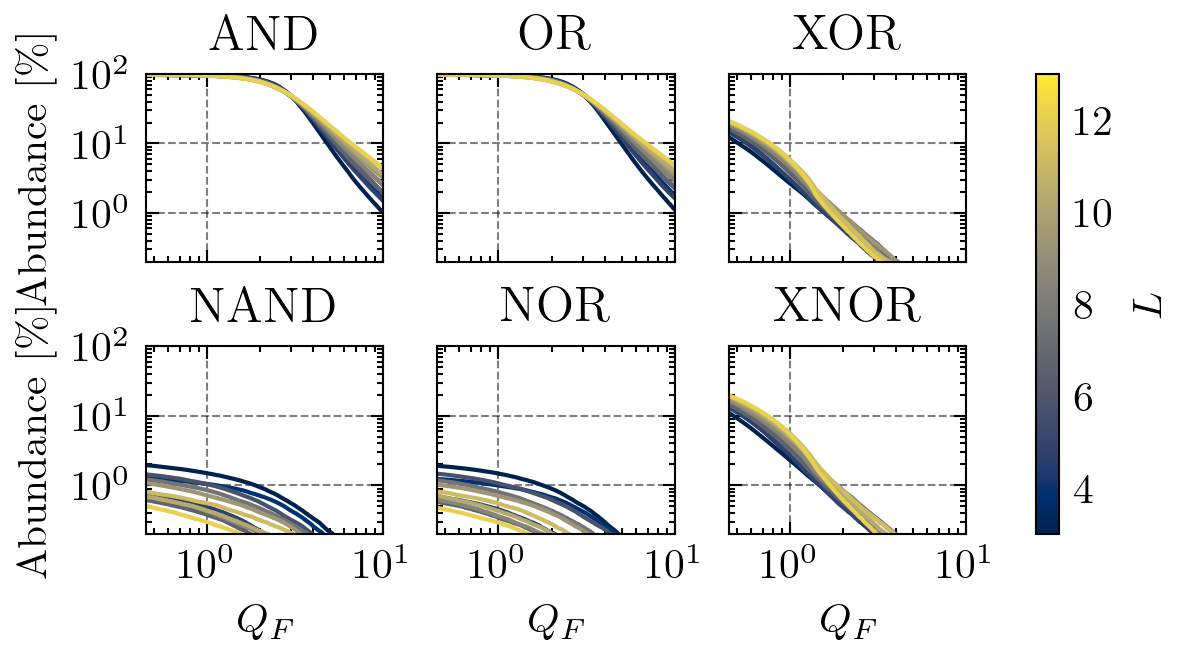

In [22]:
M_resamples = 20
fitness_tmp = {N : fitness(data_scale[N], input_cols=['E1','E3'], M=M_resamples, delta=delta) for N in data_scale.keys()}
abundance_wo_scale = {N : abundance(df=fitness_tmp[N]) for N in fitness_tmp.keys()}
fig, ax = abundance_multiplot(abundance_wo_scale, gates=['AND','OR','XOR','NAND','NOR','XNOR'])

fig.savefig("plots/pdf/abundance_vs_L_gate_comp_scaled.pdf", transparent=False)
fig.savefig("plots/png/abundance_vs_L_gate_comp_scaled.png", transparent=False)
fig.savefig("plots/svg/abundance_vs_L_gate_comp_scaled.svg", transparent=True)

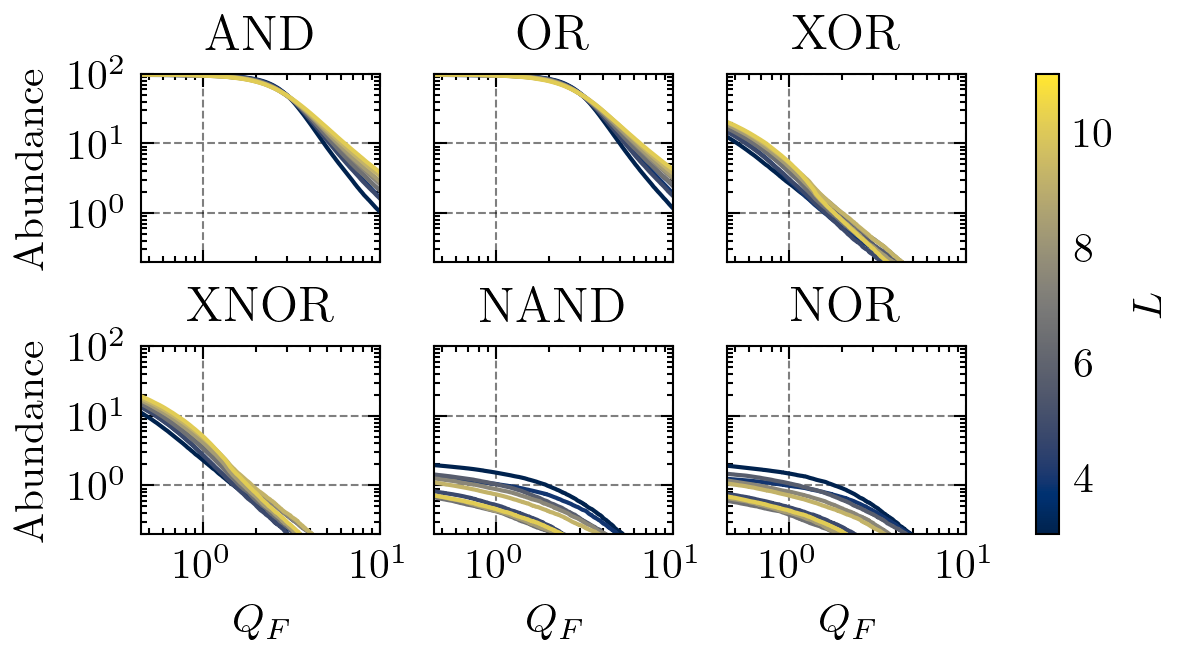

In [ ]:
fitness_tmp = {N : fitness(data_wo_scale[N], input_cols=['E1','E3'], M=M_resamples, delta=delta) for N in data_wo_scale.keys()}
abundance_scale = {N : abundance(df=fitness_tmp[N]) for N in fitness_tmp.keys()}
fig, ax = abundance_multiplot(abundance_scale)

fig.savefig("plots/pdf/abundance_vs_L_gate_comp_unscaled.pdf", transparent=False)
fig.savefig("plots/png/abundance_vs_L_gate_comp_unscaled.png", transparent=False)
fig.savefig("plots/svg/abundance_vs_L_gate_comp_unscaled.svg", transparent=True)

### Sample

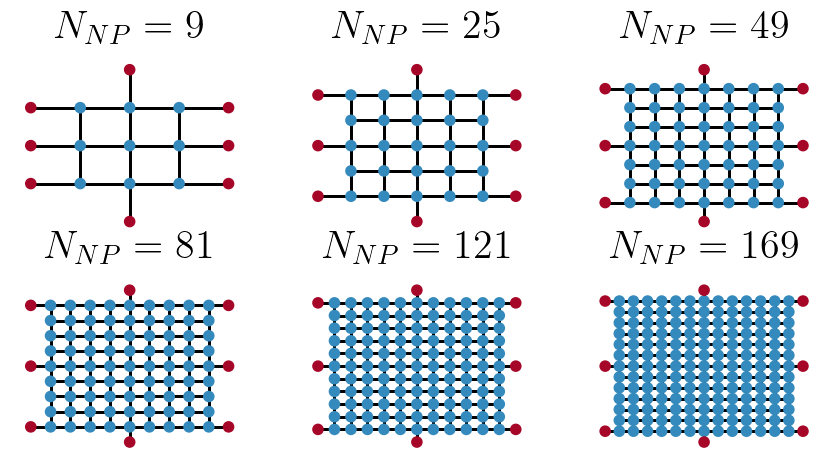

In [3]:
N_plots = [3,5,7,9,11,13]
fig     = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.)

for i, N in enumerate(N_plots):

    topology_parameter          = {
        "Nx"                :   N,
        "Ny"                :   N,
        "Nz"                :   1,
        "e_pos"             :   [[0,0,0], [int((N-1)/2),0,0], [N-1,0,0], 
                                [0,int((N-1)/2),0], [0,N-1,0], [N-1,int((N)/2),0],
                                [int((N)/2),(N-1),0], [N-1,N-1,0]],
        "electrode_type"    :   ['constant','constant','constant','constant','constant','constant','constant','constant']
    }
    sim_class   = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
    ax          = fig.add_subplot(2,3,i+1)
    fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=10, title='$N_{NP} = '+f'{N*N}$', title_size='x-large')

fig.savefig("../plots/network_sample.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/network_sample.pdf", transparent=False, bbox_inches='tight')

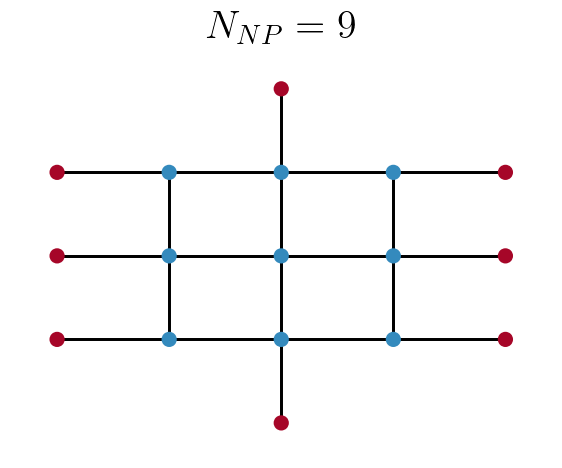

In [54]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
N       = 3
topology_parameter          = {
    "Nx"                :   N,
    "Ny"                :   N,
    "Nz"                :   1,
    "e_pos"             :   [[0,0,0], [int((N-1)/2),0,0], [N-1,0,0], 
                            [0,int((N-1)/2),0], [0,N-1,0], [N-1,int((N)/2),0],
                            [int((N)/2),(N-1),0], [N-1,N-1,0]],
    "electrode_type"    :   ['constant','constant','constant','constant','constant','constant','constant','constant']
}
sim_class   = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=20, title='$N_{NP} = '+f'{N*N}$', title_size='x-large')

fig.savefig(f"../plots/network_sample_{N}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/network_sample_{N}.pdf", transparent=False, bbox_inches='tight')

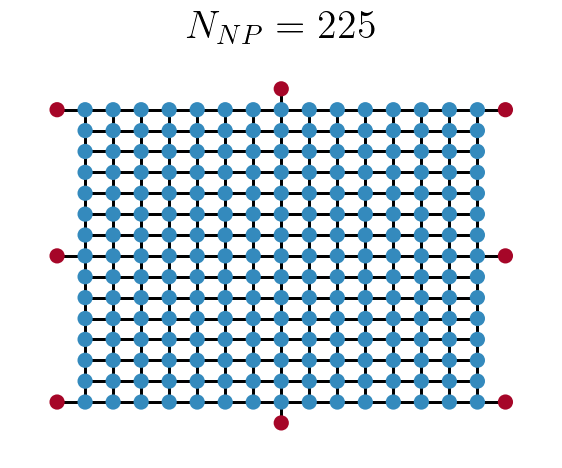

In [53]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
N       = 15
topology_parameter          = {
    "Nx"                :   N,
    "Ny"                :   N,
    "Nz"                :   1,
    "e_pos"             :   [[0,0,0], [int((N-1)/2),0,0], [N-1,0,0], 
                            [0,int((N-1)/2),0], [0,N-1,0], [N-1,int((N)/2),0],
                            [int((N)/2),(N-1),0], [N-1,N-1,0]],
    "electrode_type"    :   ['constant','constant','constant','constant','constant','constant','constant','constant']
}
sim_class   = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
fig, ax     = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=20, title='$N_{NP} = '+f'{N*N}$', title_size='x-large')

fig.savefig(f"../plots/network_sample_{N}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/network_sample_{N}.pdf", transparent=False, bbox_inches='tight')

In [8]:
def abundance_multiplot(data: Dict, gates: List[str] = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR'], 
    dpi: int = 200, x_limits: List[float] = [0.45, 10], y_limits: List[float] = [1.0, 100], 
    xlabel: str = 'Fitness', ylabel: str = 'Abundance', n_rows=2, n_cols=3, colormap='cividis') -> Tuple[plt.Figure, plt.Axes]:

    cmap    = plt.get_cmap(colormap)
    N_vals  = len(data.keys())

    with plt.style.context(["science","bright","grid"]):
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, dpi=dpi, layout='constrained')
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.1)

        for i, gate in enumerate(gates):
            ax      = axes.flat[i]
            keys    = []
            for j, (key, df) in enumerate(data.items()):
                ax.plot(df[f'{gate} Fitness'], df[f'{gate} Fitness Abundance'], color=cmap((j)/N_vals))
                keys.append(key)
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_limits[0], y_limits[1])
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            if i >= (n_rows-1)*n_cols:
                ax.set_xlabel(xlabel)
            else:
                ax.set_xticklabels("")

            if i % n_cols == 0:
                ax.set_ylabel(ylabel)
            else:
                ax.set_yticklabels("")

            ax.set_title(gate)

        norm    = mpl.colors.Normalize(vmin=np.min(keys)**2, vmax=np.max(keys)**2)
        cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
        fig.colorbar(cbar, ax=axes.ravel(), label='$N_{NP}$')

    return fig, ax

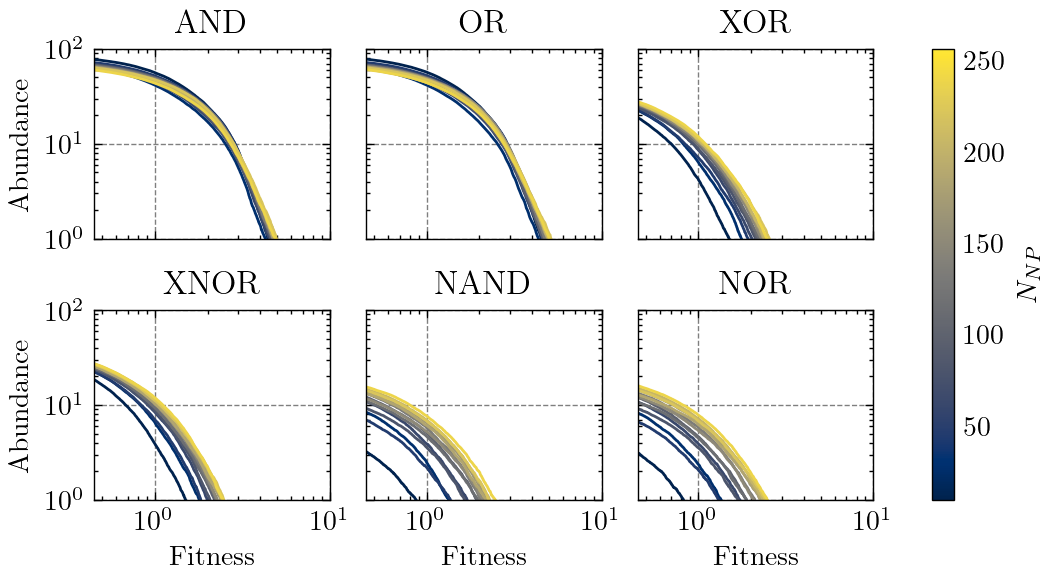

In [4]:
fig, ax = abundance_multiplot(abundance)
fig.savefig(f"../plots/abundance/gate_vs_system_size_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/abundance/gate_vs_system_size_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

In [50]:
nand_fitness_3  = fitness[3].loc[:,'NAND Fitness'].copy().values
nand_fitness_16 = fitness[15].loc[:,'NAND Fitness'].copy().values
nand_fitness    = pd.DataFrame([nand_fitness_3, nand_fitness_16])
nand_fitness    = nand_fitness.T.melt(var_name='$N_{NP}$', value_name='NAND Fitness').dropna().reset_index(drop=True).replace(to_replace=0, value=9).replace(to_replace=1, value=256)
nand_fitness    = nand_fitness[nand_fitness>0].reset_index(drop=True)

xor_fitness_3   = fitness[3].loc[:,'XOR Fitness'].copy().values
xor_fitness_16  = fitness[15].loc[:,'XOR Fitness'].copy().values
xor_fitness     = pd.DataFrame([xor_fitness_3, xor_fitness_16])
xor_fitness     = xor_fitness.T.melt(var_name='$N_{NP}$', value_name='XOR Fitness').dropna().reset_index(drop=True).replace(to_replace=0, value=9).replace(to_replace=1, value=256)
xor_fitness     = xor_fitness[xor_fitness>0].reset_index(drop=True)

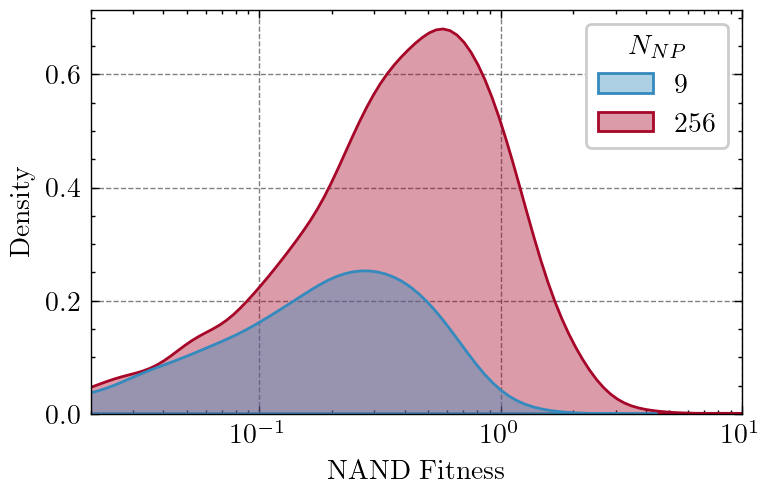

In [49]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
# ax  = sns.histplot(nand_fitness, x='NAND Fitness', ax=ax, hue='$N_{NP}$', stat='density',
#                    log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color])
ax  = sns.kdeplot(nand_fitness, x='NAND Fitness', ax=ax, hue='$N_{NP}$',
                   log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color], fill=True, alpha=0.4)
ax.set_xlim(2e-2, 1e1)
# ax.set_xlim(-5,5)
fig.savefig("../plots/nand_fitness_comparsion.svg", transparent=True, bbox_inches='tight')

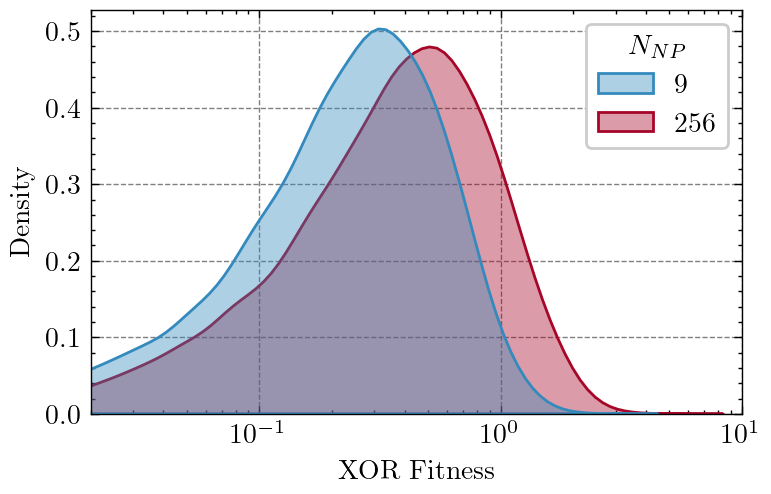

In [51]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
# ax  = sns.histplot(xor_fitness, x='XOR Fitness', ax=ax, hue='$N_{NP}$', stat='density',
#                    log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color])
ax  = sns.kdeplot(xor_fitness, x='XOR Fitness', ax=ax, hue='$N_{NP}$',
                   log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color], fill=True, alpha=0.4)
ax.set_xlim(2e-2, 1e1)
fig.savefig("../plots/xor_fitness_comparsion.svg", transparent=True, bbox_inches='tight')

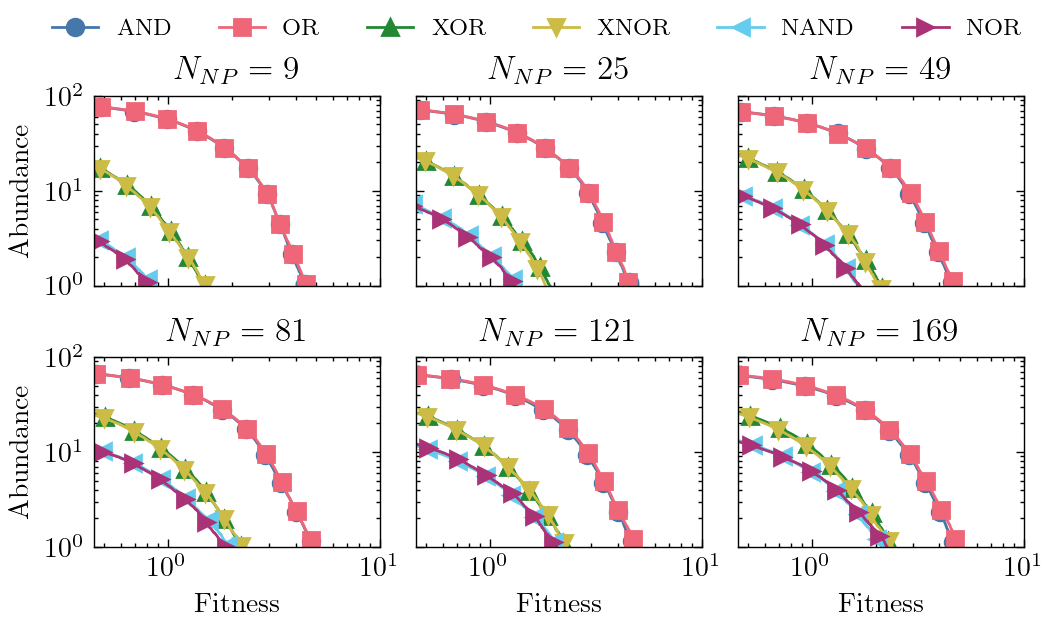

In [5]:
N_plots = [3,5,7,9,11,13]
gates   = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']
marker  = ['o','s','^','v','<','>']
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.1)

for i, N in enumerate(N_plots):

    ax  = plt.subplot(2,3,i+1)
    for j, gate in enumerate(gates):
        ax.plot(abundance[N][f'{gate} Fitness'], abundance[N][f'{gate} Fitness Abundance'], label=gate, marker=marker[j % len(marker)], markevery=0.1)
    
    ax.set_xlim(0.45, 10)
    ax.set_ylim(1.0, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('$N_{NP} = '+f'{N*N}$')
    
    if i % 3 == 0:
        ax.set_ylabel("Abundance")
    else:
        ax.set_yticklabels("")
    if i > 2:
        ax.set_xlabel("Fitness")
    else:
        ax.set_xticklabels("")
    
    if i==0:
        leg = ax.legend(loc='center', bbox_to_anchor=(1.55,1.35), ncol=6, fontsize='small')

leg.set_in_layout(False)
fig.canvas.draw()
leg.set_in_layout(True)
fig.set_layout_engine('none')
fig.savefig(f"../plots/abundance/system_size_comparison_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/abundance/system_size_comparison_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

### Best Gates

In [11]:
N       = 11
gate    = 'XOR'
best_g  = nanonets_utils.get_best_logic_gate(data[N], fitness[N], gate)
best_g

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Current,Error
0,-0.042685,0.00,-0.038521,0.00,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,165000.0,96.498867,4.491121
1,-0.042685,0.00,-0.038521,0.01,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,225000.0,103.607082,4.749572
2,-0.042685,0.01,-0.038521,0.00,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,205000.0,103.538315,4.681723
3,-0.042685,0.01,-0.038521,0.01,-0.068013,0.065557,0.099178,0.018244,0.0,100000.0,115000.0,95.936037,3.951228


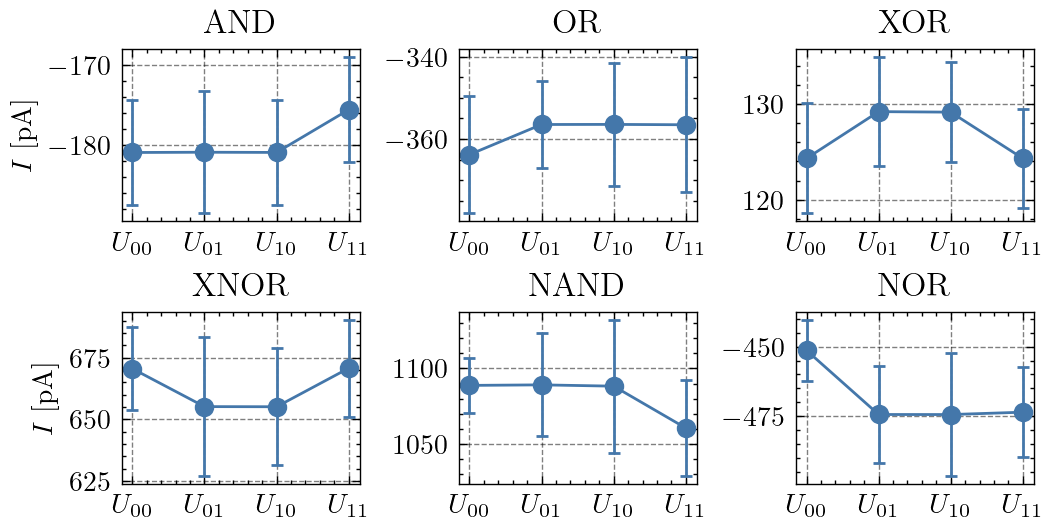

In [29]:
N = 9

with plt.style.context(["science","bright","grid"]):
    
    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*1)

    for i, gate in enumerate(['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']):

        best_g  = nanonets_utils.get_best_logic_gate(data[N], fitness[N], gate)
        ax      = fig.add_subplot(2,3,i+1)
        ax.errorbar(["$U_{00}$","$U_{01}$","$U_{10}$","$U_{11}$"], best_g['Current'], best_g['Error'], marker='o', capsize=2)
        ax.set_title(gate)

        if i % 3 == 0:
            ax.set_ylabel("$I$ [pA]")

fig.savefig(f"../plots/best_gates_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/best_gates_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

In [66]:
max_jumps_portion   = [100*((data[N]['Jumps']==1e7).sum() / len(data[N])) for N in N_vals]
rel_error_dist      = [100*np.abs(data[N]['Error'].values / data[N]['Current'].values) for N in N_vals]

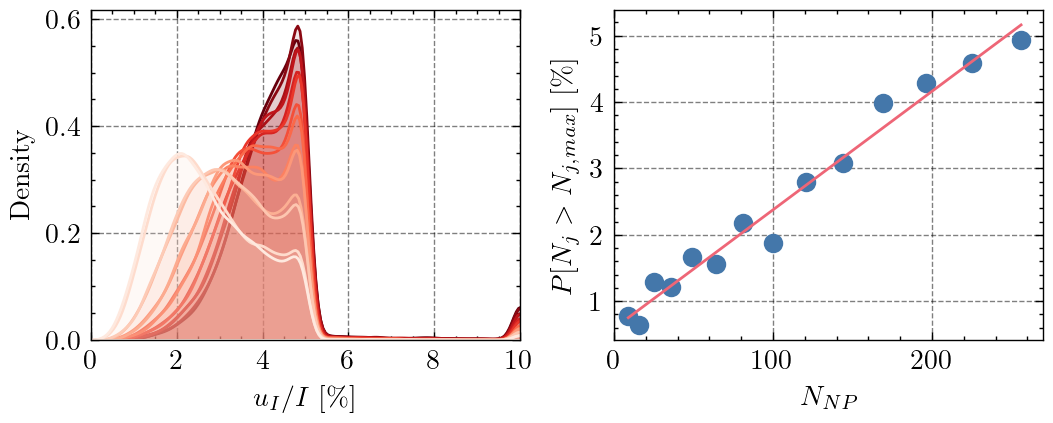

In [67]:
def lin_func(x, a, b):
    return a*x + b

with plt.style.context(["science","bright","grid"]):

    cmap    = plt.get_cmap('Reds')
    fig     = plt.figure(dpi=200, layout='constrained')
    ax1     = fig.add_subplot(1,2,1)
    ax2     = fig.add_subplot(1,2,2)
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*0.8)

    for i, arr in enumerate(rel_error_dist[::-1]):
        arr[arr>10] = 10
        ax1         = sns.kdeplot(arr, ax=ax1, color=cmap((len(rel_error_dist)-i)/len(rel_error_dist)), fill=True, alpha=0.1)

    ax1.set_xlim(0,10)
    ax1.set_xlabel('$u_I / I$ [\%]')

    x       = np.array(N_vals)**2
    y       = max_jumps_portion
    p, _    = curve_fit(lin_func, x, y)
    ax2.plot(x, y, 'o')
    ax2.plot(x, lin_func(x,*p), '-')
    ax2.set_xlabel('$N_{NP}$')
    ax2.set_ylabel('$P[N_{j} > N_{j,max}]$ [\%]')
    ax2.set_xlim(0,270)

    fig.savefig("../plots/data_quality_vs_system_size.svg", transparent=True, bbox_inches='tight')
    fig.savefig("../plots/data_quality_vs_system_size.pdf", transparent=False, bbox_inches='tight')